In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt

device = torch.device('cuda') 

In [13]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device==torch.device('cuda') else {}

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=512,
                                          shuffle=True, **kwargs)

test_set = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=512,
                                         shuffle=False, **kwargs)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [24]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=0, dilation=1)
        self.fc1 = nn.Linear(in_features=12544, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=12544)
        self.convT1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=0)
        self.convT2 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=0)

        self.drop = nn.Dropout(p=0.5)

    def encoder(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
    def decoder(self, x):
        x = self.fc2(x)
        x = x.view(x.size(0), 64, 14, 14)
        x = F.relu(x)
        x = self.convT1(x)
        x = F.relu(x)
        x = self.convT2(x)
        return torch.sigmoid(x)
    
    def forward(self, x):
        l = self.encoder(x)
        l = self.drop(l)
        output = self.decoder(l)
        return output
    
model = Net().to(device)

# Let's define an optimizer

optimizer = optim.Adam(model.parameters(), lr=0.001)

# Let's define a Loss function

lossfun = nn.MSELoss()

In [25]:
epochs = 1
epoch_loss = 0

for epoch in range(epochs):
    
    # iterate through train dataset
    
    for batch_idx, (data, _) in enumerate(train_loader):
        
        data = data.to(device)
        
        # get output
        output = model(data)
        
        # compute loss function
        loss = lossfun(output, data)
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # run optimizer 
        optimizer.step()
        
        # bookkeeping
        epoch_loss += loss.item() * data.size(0)
        
        if batch_idx % 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    print('Train Epoch: {}\tAverage Loss: {:.6f}'.format(
        epoch+1, epoch_loss/len(train_loader.dataset)))
            
# save network
torch.save(model.state_dict(), "cifar10_ae.pt")

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.564812
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.254615
Train Epoch: 1	Average Loss: 0.263703


In [20]:
# put model in the evaluation mode
model.eval()
test_loss = 0

with torch.no_grad(): # no need to compute gradients; also saves time and memory
    
    # iterate through test set
    for data, _ in test_loader:
        data = data.to(device)
        
        # forward pass
        output = model(data)
        
        # bookkeeping
        test_loss += F.binary_cross_entropy(output, data, reduction='mean').item()*data.size(0)  # loss

test_loss /= len(test_loader.dataset)

print('\nTest set: Average Loss: {:.4f}\n'.format(
    test_loss))


Test set: Average Loss: -5.0671



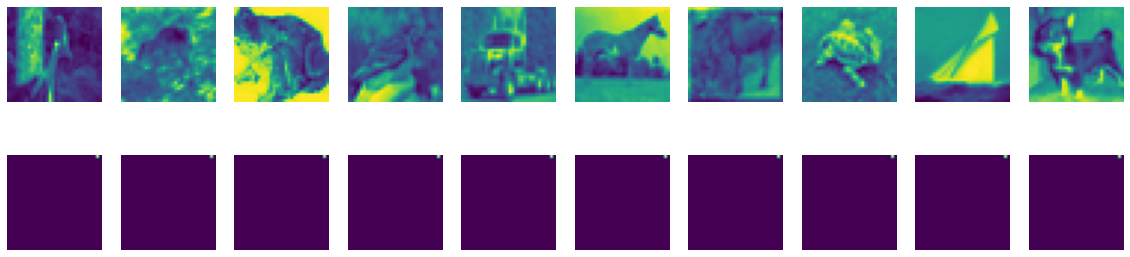

In [21]:
plt.close('All')
plt.figure(figsize=(20,5))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(data[i,0].cpu())
    plt.axis('off')
    plt.subplot(2,10,10+i+1)
    plt.imshow(output[i,0].detach().cpu())
    plt.axis('off')
    
plt.show()